In [1]:
import math
import os
import argparse

import numpy as np
import torch as th
import torch.nn.functional as F
import time
from RePaint import conf_mgt
from RePaint.utils import yamlread
from RePaint.guided_diffusion import dist_util

In [2]:
print(os.getcwd())
os.chdir("..")
print(os.getcwd())

D:\M.Arch\MastersThesis\ArchGaussian-Project\arch-gaussian\RePaint
D:\M.Arch\MastersThesis\ArchGaussian-Project\arch-gaussian


In [3]:
from RePaint.guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

In [4]:
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample


In [5]:
from PIL import Image
import numpy as np

def tensor_to_image(tensor: th.Tensor):
    tensor = th.clamp(tensor, -1.0, 1.0)
    img_arr = tensor.detach().cpu().squeeze().numpy() * 0.5 + 0.5  # remap to 0 to 1
    pil_image = Image.fromarray((img_arr * 255).astype('uint8').transpose((1, 2, 0)))
    return pil_image


## using repaint manager

In [6]:
from RePaint.repaint_manager import RepaintManager
rm = RepaintManager(conf_path="./Repaint/confs/test.yml")


Start city_example


In [7]:
# 从默认路径获取
# gt, gt_keep_mask = rm.debug_get_gt_and_gt_keep_mask()

In [8]:
# print(gt_keep_mask.shape)

In [9]:
# 从本地文件获取
from PIL import Image
import torchvision.transforms as transforms

def load_image_from_path(path:str):
    image = Image.open(path)
    
    # 定义转换
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 将图像调整为指定的大小
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 将像素值归一化到[-1, 1]
    ])

    image = transform(image).unsqueeze(0) 
    return image

gt = load_image_from_path("./gt.png")
gt_keep_mask = load_image_from_path("./gt_keep_mask.png") * 0.5 + 0.5

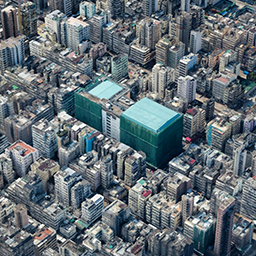

In [10]:
tensor_to_image(gt)

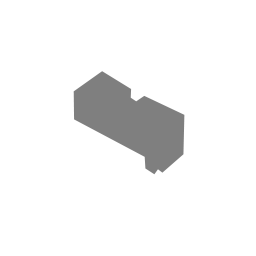

In [11]:
tensor_to_image(gt_keep_mask)


In [12]:
rm.conf_arg.schedule_jump_params['t_T']

125

In [13]:
print(gt.device)

cpu


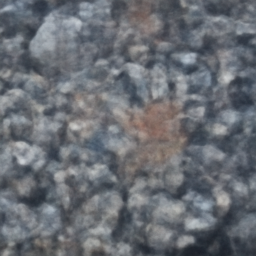

In [15]:
pred_xstart = None
sample = None

sample, pred_xstart, out, noise, part2 = rm.take_one_sample(gt, gt_keep_mask, sample, 123)
tensor_to_image(pred_xstart)

# 手动loop

In [16]:
import os.path
import torch as th
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont

def get_combined_image(img1:th.Tensor,
                img2: th.Tensor,
                img1_name:str,
                img2_name:str):
    # 创建转换函数，将 tensor 转换为 PIL 图像
    tensor_to_pil = transforms.ToPILImage()

    img11 = img1 * 0.5 + 0.5
    img22 = img2 * 0.5 + 0.5
    img11 = th.clamp(img11, 0, 1)
    img22 = th.clamp(img22, 0, 1)
    # 创建两个 PIL 图像对象
    pil_image1 = tensor_to_pil(img11.squeeze(0))
    pil_image2 = tensor_to_pil(img22.squeeze(0))

    # 在图像上写上名字
    font = ImageFont.load_default()
    draw1 = ImageDraw.Draw(pil_image1)
    draw2 = ImageDraw.Draw(pil_image2)

    draw1.text((10, 10), img1_name, font=font, fill=(255, 255, 255, 128))
    draw2.text((10, 10), img2_name, font=font, fill=(255, 255, 255, 128))

    # 创建一个新的图片，将两张图片拼接在一起
    combined_image = Image.new('RGB', (512, 256))
    combined_image.paste(pil_image1, (0, 0))
    combined_image.paste(pil_image2, (256, 0))

    return combined_image

In [52]:
pred_xstart = None
sample = None
t = 125


100%|██████████| 80/80 [00:12<00:00,  6.66it/s]


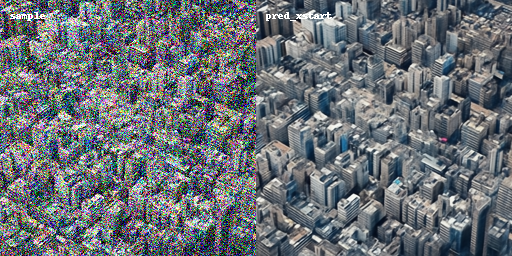

In [53]:
from tqdm import tqdm
for i in tqdm(range(80)):
    # print(f"curr_t = {t}")
    sample, pred_xstart, out, noise, part2 = rm.take_one_sample(gt, gt_keep_mask, sample, t)
    t = t - 1
    
get_combined_image(sample, pred_xstart, "sample", "pred_xstart")

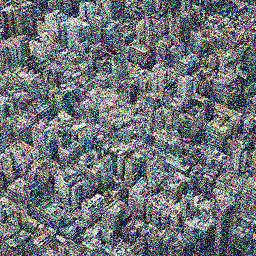

In [54]:
# 手动计算sample
tensor_to_image(out['mean'] + part2)

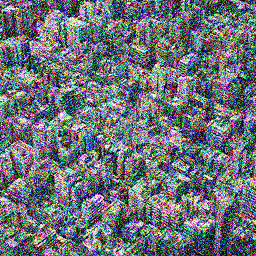

In [36]:
# 手动计算out['mean']


tt = th.tensor([t] * gt.shape[0], device=rm.device)
model_mean, _, _ = rm.diffusion.q_posterior_mean_variance(x_start=pred_xstart, x_t=sample, t=tt)
tensor_to_image(model_mean)

tensor(0.1200, device='cuda:0') tensor(0.1208, device='cuda:0')


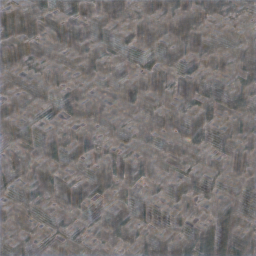

In [64]:
val = th.exp(0.5 * out["log_variance"])
print(th.min(val), th.max(val))
tensor_to_image((val - 0.1204) * 1000)

100%|██████████| 60/60 [00:09<00:00,  6.62it/s]


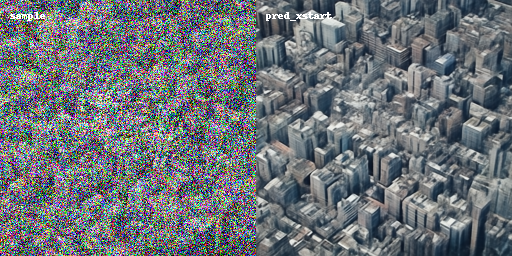

In [67]:
# 尝试自己写添加噪声的方法

pred_xstart = None
sample = th.randn_like(gt, device=rm.device)
t = 124

from tqdm import tqdm
for i in tqdm(range(60)):
    # print(f"curr_t = {t}")
    image_after_step, pred_xstart, out, noise, part2 = rm.take_one_sample(gt, gt_keep_mask, sample, t)
    # we do not use image_after_step
    tt = th.tensor([t] * gt.shape[0], device=rm.device)
    model_mean, _, _ = rm.diffusion.q_posterior_mean_variance(x_start=pred_xstart, x_t=sample, t=tt)
    nonzero_mask = (
                (tt != 0).float().view(-1, *([1] * (len(sample.shape) - 1)))
            )
    sample = model_mean + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
    
    t = t - 1
    
get_combined_image(sample, pred_xstart, "sample", "pred_xstart")

100%|██████████| 120/120 [00:18<00:00,  6.51it/s]


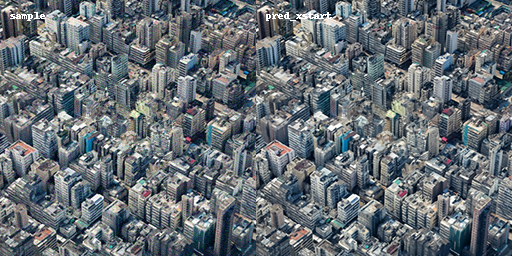

In [72]:
# 尝试自己写添加噪声的方法2

pred_xstart = None
sample = th.randn_like(gt, device=rm.device)
t = 124

from tqdm import tqdm
for i in tqdm(range(120)):
    # print(f"curr_t = {t}")
    image_after_step, pred_xstart, out, _, _ = rm.take_one_sample(gt, gt_keep_mask, sample, t)
    # we do not use image_after_step
    tt = th.tensor([t] * gt.shape[0], device=rm.device)
    model_mean, posterior_variance, posterior_log_variance_clipped = rm.diffusion.q_posterior_mean_variance(x_start=pred_xstart, x_t=sample, t=tt)
    nonzero_mask = (
                (tt != 0).float().view(-1, *([1] * (len(sample.shape) - 1)))
            )
    noise = th.randn_like(gt, device=rm.device)
    sample = model_mean + nonzero_mask * th.exp(0.5 * posterior_log_variance_clipped) * noise
    
    t = t - 1
    
get_combined_image(sample, pred_xstart, "sample", "pred_xstart")

In [237]:
# 尝试自己写添加噪声的方法3

pred_xstart = None
sample = th.randn_like(gt, device=rm.device)
t = 124



100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

71 0.33177599999999996


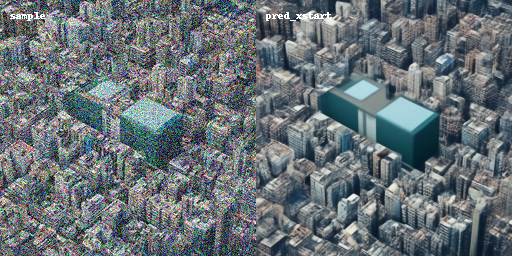

In [265]:
from tqdm import tqdm
import math
gt = gt.to(rm.device)
for i in tqdm(range(2)):
    # print(f"curr_t = {t}")
    
    image_after_step, pred_xstart, out, _, _ = rm.take_one_sample(gt, gt_keep_mask, sample, t)
    # we do not use image_after_step
    p = t / 125.0
    p = math.pow(p, 2)
    noise = th.randn_like(gt, device=rm.device)
    sample = noise * (p) + gt * (1 - p)
    sample = th.clamp(sample, -1.0, 1.0)
    t = t - 1
print(t, p)
get_combined_image(sample, pred_xstart, "sample", "pred_xstart")

## 多张图片切换

In [71]:

gt = load_image_from_path("./gt.png")
gt_keep_mask = load_image_from_path("./gt_keep_mask.png") * 0.5 + 0.5

gt2 = load_image_from_path("./gt2.png")
gt_keep_mask2 = load_image_from_path("./gt_keep_mask2.png") * 0.5 + 0.5

gts = [gt, gt2]
gt_keep_masks = [gt_keep_mask, gt_keep_mask2]

In [70]:

gt = gt.to(rm.device)
pred_xstarts = [None, None]
samples = [th.randn_like(gt, device=rm.device), th.randn_like(gt, device=rm.device)]
t = 124

from tqdm import tqdm
for i in tqdm(range(120)):
    idx = i % 2
    _, pred_xstarts[idx], out, _, _ = rm.take_one_sample(gts[idx], gt_keep_masks[idx], samples[idx], t)
    
    samples[idx]
    
    t = t - 1
    
get_combined_image(sample, pred_xstart, "sample", "pred_xstart")